In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
import json

In [2]:
def Dorfman(model, where):

    if where == gp.GRB.Callback.MIPSOL:
        EQ = 0
        for s in escenarios:
            sub = gp.Model()
            sub.params.OutputFlag = 0

            x2 = sub.addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x2")
            y2 = sub.addVars(grupos, vtype=gp.GRB.BINARY, name="y2")
            
            sub.addConstrs(sum(x2[i, j] for j in individuos) <= GT for i in grupos)
            sub.addConstrs(y2[i]*1e6 >= sum(model.cbGetSolution(x1[GT][i, j]) * ret[s, j] for j in individuos) for i in grupos)
            sub.addConstrs(x2[i, j] >= model.cbGetSolution(x1[GT][i, j])*y2[i] + model.cbGetSolution(z1[GT][i])-1 for j in individuos for i in grupos)

            sub.setObjective(sum(x2[i, j] for i in grupos for j in individuos), gp.GRB.MINIMIZE)

            sub.optimize()
            EQ += sub.objVal
        EQ = EQ/S
        model.cbLazy(EQ <= theta[GT])

## Leer data

In [3]:
with open("prevalencia.json", "r") as file:
    diccionario = json.load(file)

pDorfman = []
prevalencia = []
resultados = []
for a, b in diccionario.items():
    pDorfman.append(float(a))
    prevalencia.append(np.array(b["prevalencia"])[0:346])
    resultados.append(np.array(b["resultado"])[0:346])
pDorfman = np.array(pDorfman)
prevalencia = np.array(prevalencia) 
resultados = np.array(resultados)


## Experimento 1
- Prevalencias reales desconocidas.
- Se asumen todas constantes con valor igual al promedio de las prevalencias desconocias.

### Procedimiento
1. Se toma un vector de prevalencias constantes y se calcula la configuración óptima 
2. Se teste el rendimiento de esta configuración usando las prevalencias reales

In [4]:
I = prevalencia.shape[1] # Cantidad de personas
S = 5 # Cantidad de simulaciones
alpha = 5*I # Cantidad de test disponibles
beta = 0.2 # Cantidad de volumen de muestra que necesita un test
delta = 0.3 # Umbral para solo testear

individuos = range(I)
muestras = 2*np.ones(I)
escenarios = range(S)

# real_p = np.round(np.random.uniform(low=0.01, high=0.5, size=I), decimals=2)
# real_p = 
# p = np.mean(real_p)
# hat_p = np.ones(I)*p

### Parte 1: Prevalencias constantes

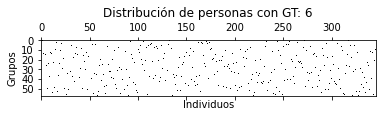

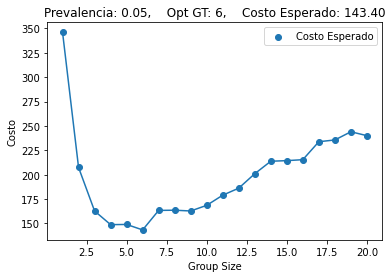

El resultado final usando la configuración es: 154.0


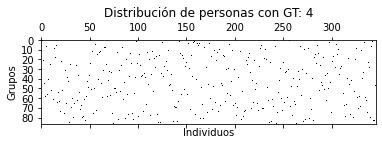

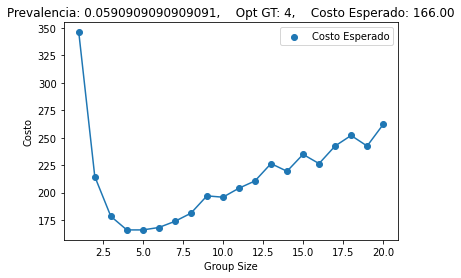

El resultado final usando la configuración es: 175.0


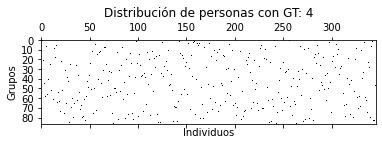

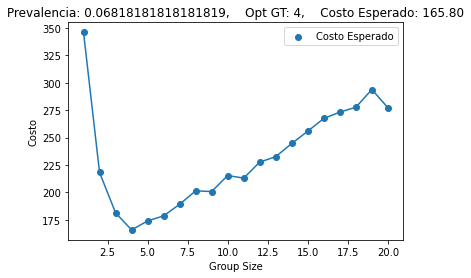

El resultado final usando la configuración es: 187.0


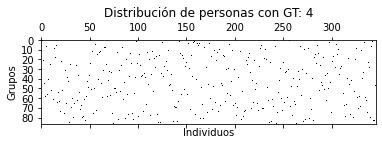

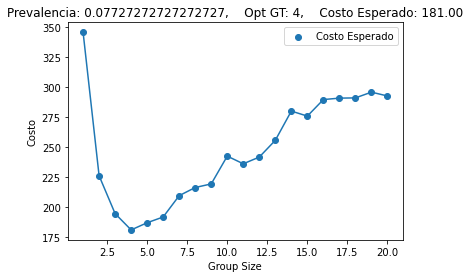

El resultado final usando la configuración es: 199.0


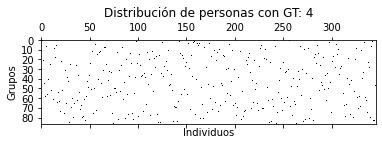

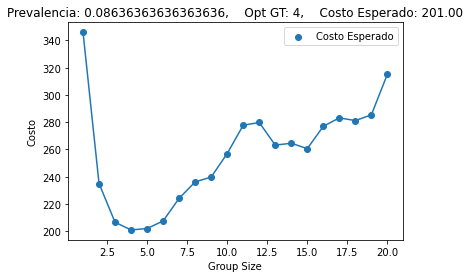

El resultado final usando la configuración es: 199.0


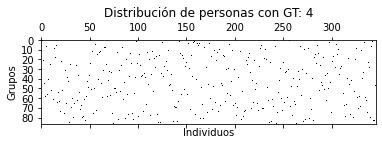

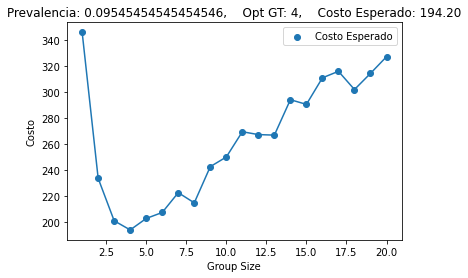

El resultado final usando la configuración es: 199.0


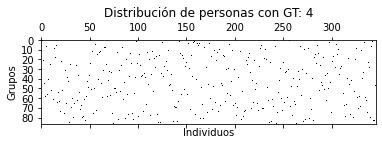

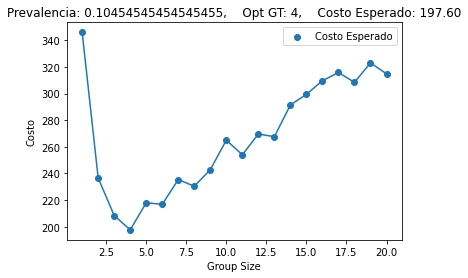

El resultado final usando la configuración es: 199.0


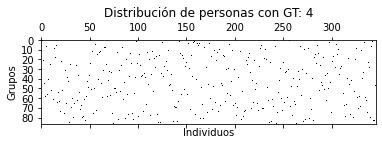

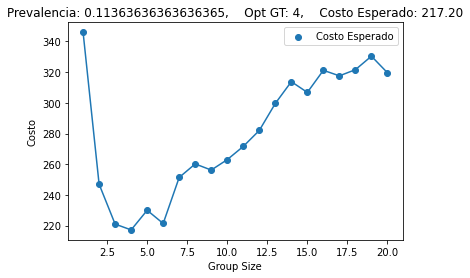

El resultado final usando la configuración es: 199.0


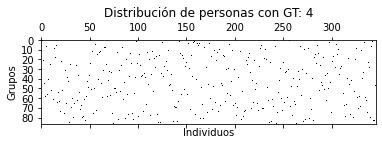

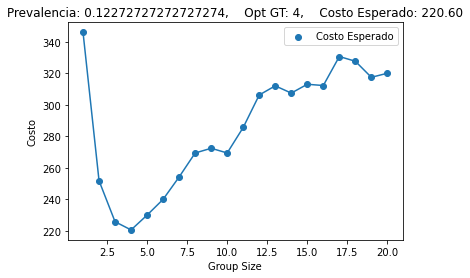

El resultado final usando la configuración es: 295.0


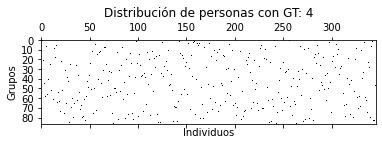

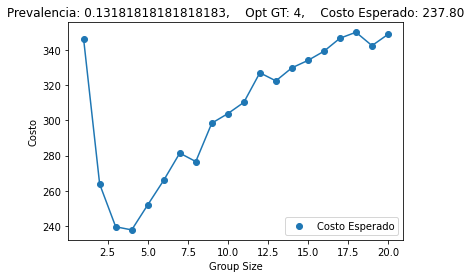

El resultado final usando la configuración es: 295.0


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_5960\1565138556.py", line 14, in Dorfman
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_5960\1565138556.py", line 14, in <genexpr>
KeyboardInterrupt: 


In [8]:
for i in range(len(pDorfman)):
    p = pDorfman[i]
    hat_p = np.ones(I)*p
    ret = np.array([[np.random.binomial(n=1, p=x) for x in hat_p] for _ in escenarios])
    
    val = []
    x1 = {}
    y1 = {}
    z1 = {}
    theta = {}
    master = {}
    for GT in range(1,21):
        G = int(np.ceil(I/GT))
        grupos = range(G)
        L = 0
        
        master[GT] = gp.Model()
        master[GT].params.OutputFlag = 0
        master[GT].params.LazyConstraints = 1

        x1[GT] = master[GT].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x1")
        y1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="y1")
        z1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="z1")
        theta[GT] = master[GT].addVar(lb=L)

        master[GT].addConstrs(y1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) for i in grupos) #R1
        master[GT].addConstrs(z1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) - 1 for i in grupos) #R2
        master[GT].addConstrs(sum(x1[GT][i, j] for i in grupos) >= 1 for j in individuos) #R3
        # master[GT].addConstr(sum(y1[GT][i] for i in grupos) <= alpha) #R4
        # master[GT].addConstrs(sum(muestras[j]*x1[GT][i,j] for i in grupos) >= beta for j in individuos) #R5
        # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos) #R6
        # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos)

        master[GT].addConstrs(sum(x1[GT][i, j] for j in individuos) <= GT for i in grupos) #R7
        master[GT].addConstr(sum(x1[GT][i, j] for i in grupos for j in individuos) >= I) #R8

        master[GT].setObjective(sum(y1[GT][j] for j in grupos) + theta[GT], gp.GRB.MINIMIZE)

        master[GT].optimize(Dorfman)
        val.append(master[GT].objVal)

    GTO = val.index(min(val)) + 1
    G = int(np.ceil(I/GTO))


    config = np.zeros((G, I))
    ik, jk = -1, -1
    for var in master[GTO].getVars():
        if "x1" in var.VarName:
            jk += 1
            if jk % I == 0:
                ik += 1
                jk = 0

            if var.X == 1:
                config[ik, jk] = 1
    plt.spy(config)
    plt.title(f"Distribución de personas con GT: {GTO}")
    plt.ylabel("Grupos")
    plt.xlabel("Individuos")
    plt.show()

    plt.plot(range(1, len(val)+1), val)
    plt.scatter(range(1, len(val)+1), val, label="Costo Esperado")
    plt.title(f"Prevalencia: {p},    Opt GT: {GTO},    Costo Esperado: {master[GTO].objVal:0.2f}")
    plt.xlabel("Group Size")
    plt.ylabel("Costo")
    plt.legend()
    plt.show()

    # Se teste el rendimiento de esta configuración usando las prevalencias reales 
    gamma = config.shape[0]
    for t in resultados[i,:]:
        if t == 1:
            gamma += sum(config[t,:])    
    print(f"El resultado final usando la configuración es: {gamma}")


## Experimento 2
- Prevalencias reales conocidas.

### Procedimiento
1. Se toma el vector de las prevalencias reales y se calcula la configuración óptima 

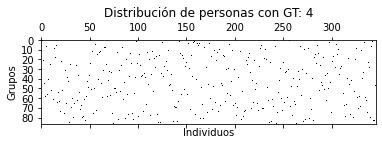

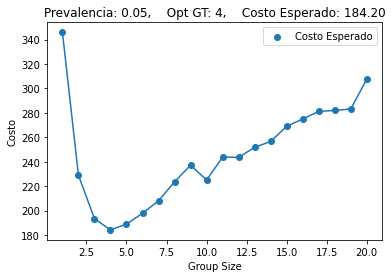

El resultado final usando la configuración es: 151.0


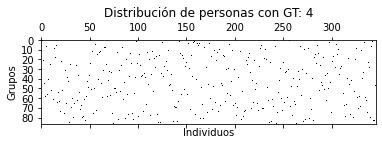

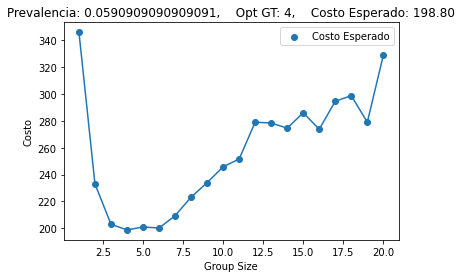

El resultado final usando la configuración es: 175.0


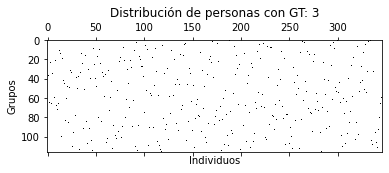

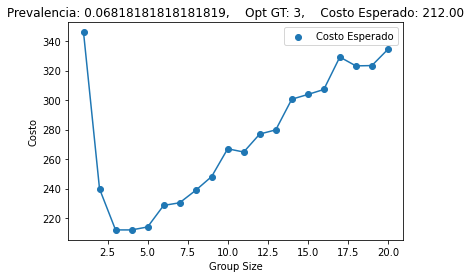

El resultado final usando la configuración es: 191.0


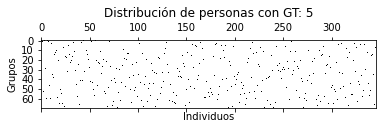

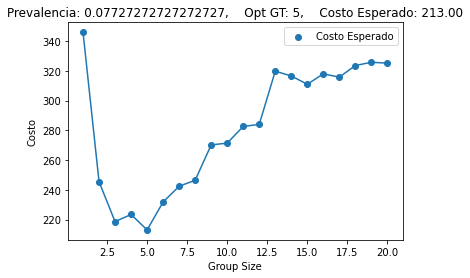

El resultado final usando la configuración es: 210.0


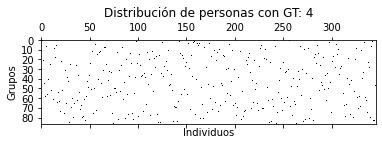

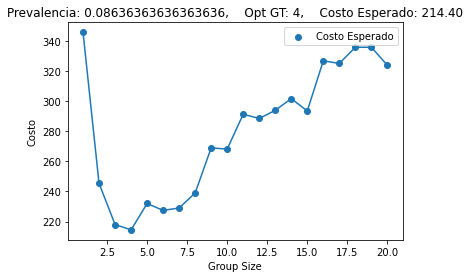

El resultado final usando la configuración es: 199.0


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_20760\1565138556.py", line 16, in Dorfman
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_20760\1565138556.py", line 16, in <genexpr>
KeyboardInterrupt: 


In [7]:
for i in range(len(pDorfman)):
    p = pDorfman[i]
    hat_p = prevalencia[i]
    ret = np.array([[np.random.binomial(n=1, p=x) for x in hat_p] for _ in escenarios])
    
    val = []
    x1 = {}
    y1 = {}
    z1 = {}
    theta = {}
    master = {}
    for GT in range(1,21):
        G = int(np.ceil(I/GT))
        grupos = range(G)
        
        L = 0
        
        master[GT] = gp.Model()
        master[GT].params.OutputFlag = 0
        master[GT].params.LazyConstraints = 1

        x1[GT] = master[GT].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x1")
        y1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="y1")
        z1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="z1")
        theta[GT] = master[GT].addVar(lb=L)

        master[GT].addConstrs(y1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) for i in grupos) #R1
        master[GT].addConstrs(z1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) - 1 for i in grupos) #R2
        master[GT].addConstrs(sum(x1[GT][i, j] for i in grupos) >= 1 for j in individuos) #R3
        # master[GT].addConstr(sum(y1[GT][i] for i in grupos) <= alpha) #R4
        # master[GT].addConstrs(sum(muestras[j]*x1[GT][i,j] for i in grupos) >= beta for j in individuos) #R5
        # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos) #R6
        # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos)

        master[GT].addConstrs(sum(x1[GT][i, j] for j in individuos) <= GT for i in grupos) #R7
        master[GT].addConstr(sum(x1[GT][i, j] for i in grupos for j in individuos) >= I) #R8

        master[GT].setObjective(sum(y1[GT][j] for j in grupos) + theta[GT], gp.GRB.MINIMIZE)

        master[GT].optimize(Dorfman)
        val.append(master[GT].objVal)

    GTO = val.index(min(val)) + 1
    G = int(np.ceil(I/GTO))


    config = np.zeros((G, I))
    ik, jk = -1, -1
    for var in master[GTO].getVars():
        if "x1" in var.VarName:
            jk += 1
            if jk % I == 0:
                ik += 1
                jk = 0

            if var.X == 1:
                config[ik, jk] = 1
    plt.spy(config)
    plt.title(f"Distribución de personas con GT: {GTO}")
    plt.ylabel("Grupos")
    plt.xlabel("Individuos")
    plt.show()

    plt.plot(range(1, len(val)+1), val)
    plt.scatter(range(1, len(val)+1), val, label="Costo Esperado")
    plt.title(f"Prevalencia: {p},    Opt GT: {GTO},    Costo Esperado: {master[GTO].objVal:0.2f}")
    plt.xlabel("Group Size")
    plt.ylabel("Costo")
    plt.legend()
    plt.show()

    
    # Se teste el rendimiento de esta configuración usando las prevalencias reales 
    gamma = config.shape[0]
    for t in resultados[i,:]:
        if t == 1:
            gamma += sum(config[t,:])
    print(f"El resultado final usando la configuración es: {gamma}")

### Exp test

1
Academic license - for non-commercial use only - expires 2023-06-21
Using license file C:\Users\jacmo\gurobi.lic
2
3
4
5


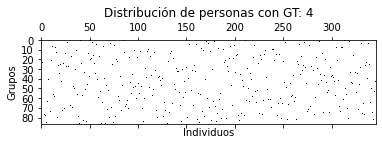

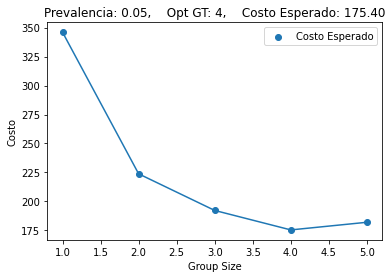

El resultado final usando la configuración es: 151.0
1
2


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_19764\1565138556.py", line 14, in Dorfman
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_19764\1565138556.py", line 14, in <genexpr>
KeyboardInterrupt: 


3


In [5]:
for i in range(len(pDorfman)):
    p = pDorfman[i]
    hat_p = prevalencia[i]
    ret = np.array([[np.random.binomial(n=1, p=x) for x in hat_p] for _ in escenarios])
    
    val = []
    x1 = {}
    y1 = {}
    z1 = {}
    theta = {}
    master = {}
    for GT in range(1,6):
        print(GT)
        gplus = 0
        for item in hat_p:
            if item >= 0.2:
                gplus += 1
        G = int(np.ceil(I/GT)) 
        grupos = range(G)
        
        L = 0
        
        master[GT] = gp.Model()
        master[GT].params.OutputFlag = 0
        master[GT].params.LazyConstraints = 1

        x1[GT] = master[GT].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x1")
        y1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="y1")
        z1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="z1")
        theta[GT] = master[GT].addVar(lb=L)

        master[GT].addConstrs(y1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) for i in grupos) #R1
        master[GT].addConstrs(z1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) - 1 for i in grupos) #R2
        master[GT].addConstrs(sum(x1[GT][i, j] for i in grupos) >= 1 for j in individuos) #R3
        # master[GT].addConstr(sum(y1[GT][i] for i in grupos) <= alpha) #R4
        # master[GT].addConstrs(sum(muestras[j]*x1[GT][i,j] for i in grupos) >= beta for j in individuos) #R5
        # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos) #R6
        # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos)

        master[GT].addConstrs(sum(x1[GT][i, j] for j in individuos) <= GT for i in grupos) #R7
        # master[GT].addConstr(sum(x1[GT][i, j] for i in grupos for j in individuos) >= I) #R8

        master[GT].setObjective(sum(y1[GT][j] for j in grupos) + theta[GT], gp.GRB.MINIMIZE)

        master[GT].optimize(Dorfman)
        val.append(master[GT].objVal)

    GTO = val.index(min(val)) + 1
    G = int(np.ceil(I/GTO)) 

    config = np.zeros((G, I))
    ik, jk = -1, -1
    for var in master[GTO].getVars():
        if "x1" in var.VarName:
            jk += 1
            if jk % I == 0:
                ik += 1
                jk = 0

            if var.X == 1:
                config[ik, jk] = 1
    plt.spy(config)
    plt.title(f"Distribución de personas con GT: {GTO}")
    plt.ylabel("Grupos")
    plt.xlabel("Individuos")
    plt.show()

    plt.plot(range(1, len(val)+1), val)
    plt.scatter(range(1, len(val)+1), val, label="Costo Esperado")
    plt.title(f"Prevalencia: {p},    Opt GT: {GTO},    Costo Esperado: {master[GTO].objVal:0.2f}")
    plt.xlabel("Group Size")
    plt.ylabel("Costo")
    plt.legend()
    plt.show()

    
    # Se teste el rendimiento de esta configuración usando las prevalencias reales 
    gamma = config.shape[0]
    for t in resultados[i,:]:
        if t == 1:
            gamma += sum(config[t,:])
    print(f"El resultado final usando la configuración es: {gamma}")

In [65]:
# hat_p = real_p el el primero es optimista
# ret = np.array([[np.random.binomial(n=1, p=x) for x in hat_p] for _ in escenarios])

# GT = int(I/2)+1
# G = int(np.ceil(I/GTO))
# grupos = range(G)
# L = 0

# master[GT] = gp.Model()
# master[GT].params.OutputFlag = 0
# master[GT].params.LazyConstraints = 1

# x1[GT] = master[GT].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x1")
# y1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="y1")
# z1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="z1")
# theta[GT] = master[GT].addVar(lb=L)

# master[GT].addConstrs(x1[GT][i,j] == config[i,j] for j in individuos for i in grupos)

# master[GT].addConstrs(y1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) for i in grupos) #R1
# master[GT].addConstrs(z1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) - 1 for i in grupos) #R2
# # master[GT].addConstrs(sum(x1[GT][i, j] for i in grupos) >= 1 for j in individuos) #R3
# # master[GT].addConstr(sum(y1[GT][i] for i in grupos) <= alpha) #R4
# # master[GT].addConstrs(sum(muestras[j]*x1[GT][i,j] for i in grupos) >= beta for j in individuos) #R5
# # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos) #R6
# # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos)

# # master[GT].addConstrs(sum(x1[GT][i, j] for j in individuos) <= GT for i in grupos) #R7
# # master[GT].addConstr(sum(x1[GT][i, j] for i in grupos for j in individuos) >= I) #R8

# master[GT].setObjective(sum(y1[GT][j] for j in grupos) + theta[GT], gp.GRB.MINIMIZE)

# master[GT].optimize(Dorfman)
# # val.append(master[GT].objVal)

# print(master[GT].objVal)

# M = np.zeros((G, I))
# i, j = -1, -1
# for var in master[GT].getVars():
#     if "x1" in var.VarName:
#         j += 1
#         if j % I == 0:
#             i += 1
#             j = 0

#         if var.X == 1:
#             M[i, j] = 1
# plt.spy(M)
# plt.title(f"Distribución de personas con GT: {GTO}")
# plt.ylabel("Grupos")
# plt.xlabel("Individuos")
# plt.show()